In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["DDE_BACKEND"] = "jax"

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

from jax import config
config.update("jax_enable_x64", True)
# config.update("jax_debug_nans", True)

import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
import optax

try:
    print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')
except:
    pass
    
import deepxde_al_patch.deepxde as dde

from deepxde_al_patch.model_loader import construct_model
from deepxde_al_patch.modified_train_loop import ModifiedTrainLoop
from deepxde_al_patch.plotters import plot_residue_loss, plot_error, plot_prediction
from deepxde_al_patch.train_set_loader import load_data

from deepxde_al_patch.ntk import NTKHelper
from deepxde_al_patch.utils import get_pde_residue, print_dict_structure

## Setup

In [18]:
inverse_problem = True

model, model_aux = construct_model(
    
# #     # load data - without pdebench
#     pde_name='reacdiff-1d', 
#     pde_const=(0.002, 0.1,), 
#     use_pdebench=False,
#     inverse_problem=inverse_problem, 
#     inverse_problem_guess=(0.05, 1.0),
#     num_domain=500, 
#     num_boundary=500, 
#     num_initial=500,
#     test_max_pts=100000,
#     include_ic=True,
    
# #     # load data - without pdebench
#     pde_name='darcy-2d', 
#     data_seed=40,
#     pde_const=(100.,), 
#     use_pdebench=True,
#     inverse_problem=inverse_problem, 
#     inverse_problem_guess=(15.,),
#     num_domain=2000, 
#     num_boundary=500, 
#     num_initial=500,
#     include_ic=(not inverse_problem),
#     data_root='~/pdebench',
#     test_max_pts=10000,
    
    # #     # load data - without pdebench
    pde_name='conv-1d', 
    data_seed=40,
    pde_const=(1.,), 
    use_pdebench=True,
    inverse_problem=inverse_problem, 
    inverse_problem_guess=(0.8,),
    num_domain=2000, 
    num_boundary=500, 
    num_initial=500,
    include_ic=(not inverse_problem),
    data_root='/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/pdebench',
    test_max_pts=50000,
    
#     #     # load data - without pdebench
#     pde_name='burgers-1d', 
#     data_seed=20,
#     pde_const=(0.02,), 
#     use_pdebench=True,
# #     inverse_problem=inverse_problem, 
# #     inverse_problem_guess=(0.8,),
#     num_domain=2000, 
#     num_boundary=500, 
#     num_initial=500,
#     include_ic=True,
#     data_root='/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/pdebench',
#     test_max_pts=50000,
    
#     # load data - without pdebench
#     pde_name='reacdiff-1d', 
#     data_seed=40,
#     pde_const=(5., 5.), 
#     use_pdebench=True,
#     inverse_problem=inverse_problem, 
#     inverse_problem_guess=(1., 1.),
#     num_domain=2000, 
#     num_boundary=500, 
#     num_initial=500,
#     include_ic=True,  #(not inverse_problem),
#     data_root='~/pdebench',
#     test_max_pts=50000,
    
    # # load data - with pdebench
    # pde_name='eik2-2d', 
    # pde_const=(),
    # use_pdebench=False,
    # inverse_problem=False, 
    # include_ic=False,
    # num_domain=40, 
    # num_boundary=5, 
    # num_initial=5,
    
    # model params
    hidden_layers=8, 
    hidden_dim=32, 
    activation='tanh', 
    initializer='Glorot uniform', 
    arch='laaf',

)

Compiling model...
'compile' took 0.080632 s



### Experiments area

In [19]:
method = 'eig_kmeans'
optim = 'adam'


if method == 'random':
    al_args = dict(
        method='pseudo',
        res_proportion=0.9,
    )

elif method == 'residue':
    al_args = dict(
        res_proportion=0.8,
        select_icbc_with_residue=False,
        select_anc_with_residue=False,
    )
    
elif method.startswith('eig'):
    al_args = dict(
        num_points_round=200,
        weight_method= "alignment", # possible options are 'none', 'labels', 'eigvals', 'labels_train
        num_candidates_res=800, #300
        num_candidates_bcs=200,
        num_candidates_init=200,
        memory = True, # True to remember old points and add on new ones
        use_init_train_pts=False,
        sampling = 'pseudo', # uniform, pseudo
        min_num_points_bcs=1,
        min_num_points_res=1,
        use_anc_in_train=False,
#         points_pool_size=5,
    )

else:
    raise ValueError
    
    
if optim == 'lbfgs':
    optim_args = dict(
        train_steps=1000,
        al_every=20,
        select_anchors_every=20,
        snapshot_every=10,
        optim_method='lbfgs', 
        optim_lr=1e-3, 
        optim_args=dict(),
    )

elif optim == 'adam':
    optim_args = dict(
        train_steps=15000,
        al_every=1000,
        select_anchors_every=1000,
        snapshot_every=1000,
        optim_method='adam', 
        optim_lr=1e-4, 
        optim_args=dict(),
    )
    

train_loop = ModifiedTrainLoop(
    model=model, 
    inverse_problem=False,
    point_selector_method=method,
    point_selector_args=al_args,
    mem_pts_total_budget=500,
    anchor_budget=0,
    autoscale_loss_w_bcs=False,
    ntk_ratio_threshold=None,
    anc_measurable_idx=0,
#     anc_measurable_idx=jnp.array([0, 1]),
    tensorboard_plots=False,
#     log_dir=f'./scrap/{datetime.now().strftime("%Y%m%d%H%M%S")}',
    **optim_args,
)

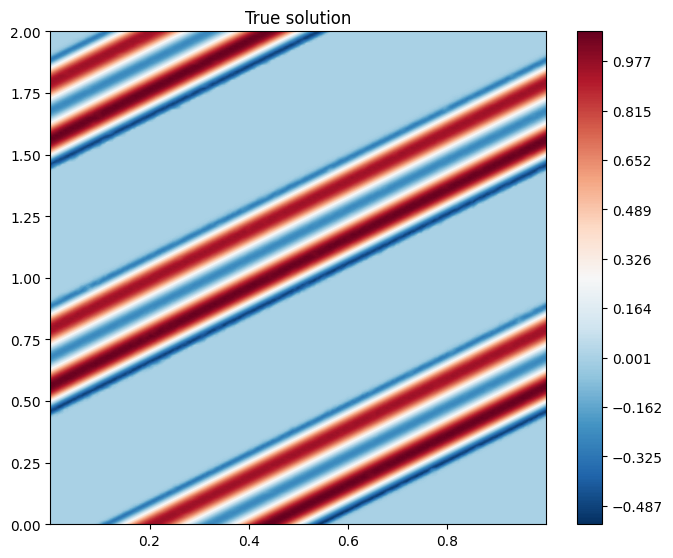

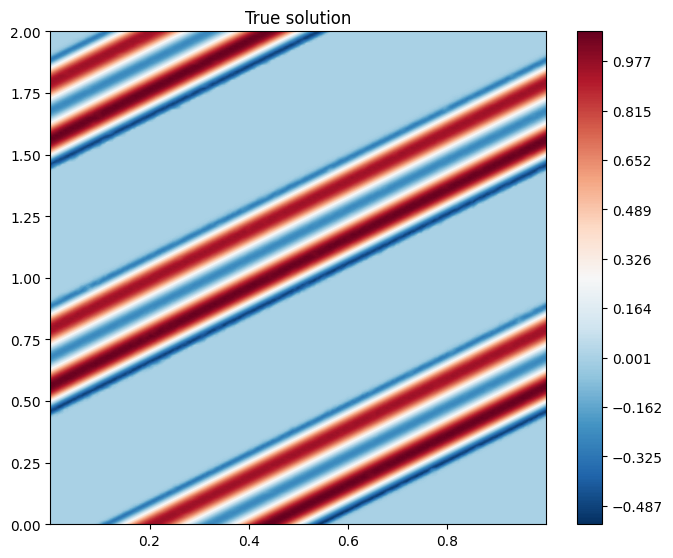

In [20]:
plot_prediction(train_loop, res=200, out_idx=0);
plot_prediction(train_loop, res=200, out_idx=1);

In [ ]:
train_loop.train()

In [ ]:
fig, _ = train_loop.plot_training_data(10000)
fig

In [ ]:
y_fn = lambda x: train_loop.net.apply(train_loop.net.params, x)

In [ ]:
model.data.pde(model.data.test_x, (y_fn(model.data.test_x), y_fn))

In [ ]:
plt.contour(model_aux['data_aux']['T_transform'](model.data.test_x, model.data.test_y).reshape(301, 301))
plt.colorbar()

In [ ]:
y_fn(model.data.test_x)

### Visualisation

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 300

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': False,
})

In [ ]:
# Visualisation

# train_loop.plot_training_data(step_idx=0)
train_loop.plot_losses()

In [ ]:
steps = [8000, 15000]

In [ ]:
plot_prediction(train_loop=train_loop, step_idxs=steps, plot_training_data=False, out_idx=0);
# plot_prediction(train_loop=train_loop, step_idxs=steps, plot_training_data=False, out_idx=1);

In [ ]:
plot_prediction(train_loop=train_loop, step_idxs=steps, plot_training_data=True, out_idx=0);
# plot_prediction(train_loop=train_loop, step_idxs=steps, plot_training_data=True, out_idx=1);